In [1]:
import pandas as pd
import numpy as np
import copy
import datetime               
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_columns',None)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso, LassoCV

In [4]:
#!pip install imblearn 

In [5]:
seed = 42
np.random.seed(seed)

# Import Merged Data

In [6]:
cm = pd.read_csv('cleaned_and_merged_data.csv')

In [7]:
cm.head()

,LPERMNO,sic,fyear,oancf/sale,ebitda/sale,gp/sale,ros,gross_margin,oancf/seq,oancf/at,ebit/seq,ebit/at,ebitda/at,roe,roa,xint/sale,effective_tax_rate,fin_lev,dltt/seq,dltt/at,wcap/at,ch/at,at/lt,lt/at,invt/at,asset_turnover,invt_turnover,invt/sale,receivable_turnover,payable_turnover,bankrupt,bankrupt_year,CPI,GDP,inflation,unemployment,spread
3,10031,Retail Trade,1987.0,-0.026421,0.002971,0.363770,0.004979,0.363770,-0.129138,-0.061526,-0.052990,-0.025246,0.006919,0.024336,0.011595,0.013438,0.421169,2.098914,0.716734,0.341479,0.301906,0.029610,1.909989,0.523563,0.743174,2.328637,1.993541,0.319146,29.507109,52.392707,0.0,1989.0,113.6,4855.2,0.0365,0.062,0.97704
4,10031,Retail Trade,1988.0,-0.064009,-0.112168,0.337966,-0.238905,0.337966,10.824742,-0.128993,22.536082,-0.268550,-0.226044,40.402062,-0.481450,0.022159,0.088499,-83.917526,-0.536082,0.006388,-0.052243,0.018550,0.988224,1.011916,0.717445,2.015233,1.859589,0.356011,15.273743,10.896048,0.0,1989.0,118.3,5236.4,0.0414,0.055,0.74760
9,54594,Wholesale Trade,1988.0,0.000231,0.125630,0.254218,0.061064,0.254218,0.000548,0.000264,0.260024,0.125186,0.143244,0.144621,0.069626,0.019217,0.329605,2.077113,0.149825,0.072131,0.317315,0.012809,1.928408,0.518562,0.393705,1.140208,2.159857,0.345292,4.267680,11.271809,0.0,2019.0,118.3,5236.4,0.0414,0.055,0.74760
10,54594,Wholesale Trade,1989.0,0.043543,0.121454,0.242639,0.057668,0.242639,0.102196,0.049858,0.247172,0.120588,0.139071,0.135348,0.066032,0.022453,0.327611,2.049724,0.381587,0.186165,0.415694,0.010409,1.952632,0.512129,0.417349,1.145048,2.077910,0.364482,4.753903,12.405538,0.0,2019.0,124.0,5641.6,0.0482,0.053,-0.07868
11,54594,Wholesale Trade,1990.0,0.079073,0.089932,0.215419,0.031725,0.215419,0.190378,0.097092,0.173916,0.088697,0.110425,0.076381,0.038954,0.021591,0.306777,1.960790,0.355835,0.181475,0.405477,0.004087,2.040810,0.490002,0.410922,1.227878,2.344411,0.334660,5.113461,13.284604,0.0,2019.0,130.7,5963.1,0.0540,0.056,0.39088


### Clean data a bit

In [8]:
cm['CPI'] = np.log10(cm['CPI'])
cm['GDP'] = np.log10(cm['GDP'])

### Remove outliers

In [9]:
# def outliers(df):
#     for i in list(df)[3:]:
#         if i not in ['sic','LPERMNO','fyear','bankrupt','bankrupt_year']:
#             df = df[abs(df[i]-df[i].mean())<3*df[i].std()]
#     return df

In [10]:
# cm = outliers(cm)
# cm

# Lag one year ahead #

In [11]:
# year_lag = lag for x years 
# e.g. a row with 2018 data -- year_lag = 2 -- (2018) 2017 2016

def lag(data, year_lag = 2):

    # change the fyear to ascend within every LPERMNO
    data.sort_values(['LPERMNO', 'fyear'], ascending = [True, True], inplace = True)

    # remove irrelevant columns first
    df = data.drop(columns = ['bankrupt','bankrupt_year'])
    
    # get the columns
    columns = df.columns
    col_to_lag = columns[2:]

    # run the loops to create lag columns to the number of lagged year
    for lag in range(1, year_lag+1):
        for colname in col_to_lag:
            df[f'{colname}'+ '_lag' + f'{lag}'] = df[f'{colname}'].shift((lag-1))

    # # calcualte delta change 
    # for lag in range(1, year_lag):
    #     for colname in col_to_lag:
    #         if (f'{colname}'+ '_lag' + f'{lag+1}' in df.columns) and colname != 'fyear':
    #             df[f'{colname}' + '_change_lagyear' +f'{lag+1}'] = (df[f'{colname}'+ '_lag' + f'{lag}'] - df[f'{colname}'+ '_lag' + f'{lag+1}'])/df[f'{colname}'+ '_lag' + f'{lag+1}']

    # add back the bankrupt info
    df['bankrupt'] = data['bankrupt']
    df['bankrupt_year'] = data['bankrupt_year']

    # keep the new lagged columns and remove the original one
    df.drop(col_to_lag, axis=1, inplace = True)

    # drop the first row of each LPERMNO after lagging one year
    # will drop companies with only one year of data (49 companies)
    df = df.groupby(['LPERMNO']).apply(lambda x: x.iloc[1:])
    df = df.set_index('LPERMNO').reset_index()    
    
    # identify the real bankrupt row
    # will drop companies goes bankrupt after >1 year after the last fiscal year of recording (96 companies)
    for i in range(len(df)):
        if (df['bankrupt'][i] == 1) & (df['bankrupt_year'][i] - df['fyear_lag1'][i] == 1):
            df['bankrupt'][i] = 1
        else:
            df['bankrupt'][i] = 0

    df['predict_year'] = df['fyear_lag1']+1

    return df

# cmcm = lag(cm[cm['tic'] == 'TSLA'],2)
cmcm = lag(cm ,2)
cmcm.head()

,LPERMNO,sic,fyear_lag1,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,fyear_lag2,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,bankrupt,bankrupt_year,predict_year
0,10001,"Transportation, Communications, Electric, Gas ...",1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,1989.0,0.077346,0.133304,0.133304,0.052728,0.133304,0.280335,0.095448,0.379845,0.129329,0.164503,0.191109,0.065069,0.028416,0.368201,2.937035,1.165955,0.396984,0.037189,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.078680,0.0,2017.0,1991.0
1,10001,"Transportation, Communications, Electric, Gas ...",1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.390880,0.0,2017.0,1992.0
2,10001,"Transportation, Communications, Electric, Gas ...",1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.030,0.075,2.238964,1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.0420,0.068,1.374600,0.0,2017.0,1993.0
3,10001,"Transportation, Communications, Electric, Gas ...",1993.0,0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418,1.265315,0.402785,0.068044,0.024969,1.466980,0.681672,0.058905,1.007108,14.605198,0.058489,10.157721,17.442551,2.159868,3.836235,0.030,0.069,1.820480,1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.0300,0.075,2.238964,0.0,2017.0,1994.0
4,10001,"Transportation, Communications, Electric, Gas ...",1994.0,0.102999,0.148121,0.148121,0.048808,0.148121,0.303524,0.101477,0.280635,0.093825,0.145933,0.143831,0.048087,0.034754,0.341871,2.991057,1.141062,0.381491,0.038945,0.018224,1.502246,0.665670,0.038726,0.985229,21.672794,0.039306,10.532725,21.898734,2.170848,3.862561,0.026,0.061,1.1

In [12]:
cmcm['bankrupt'].value_counts()

0.0    94082
1.0      272
Name: bankrupt, dtype: int64

In [13]:
cmcm[cmcm['predict_year'] != 2020]['bankrupt'].value_counts()

0.0    93410
1.0      272
Name: bankrupt, dtype: int64

## Remove predict year = 2020 

In [14]:
cmcm = cmcm[cmcm['predict_year'] != 2020]

In [15]:
cmcm

,LPERMNO,sic,fyear_lag1,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,fyear_lag2,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,bankrupt,bankrupt_year,predict_year
0,10001,"Transportation, Communications, Electric, Gas ...",1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,1989.0,0.077346,0.133304,0.133304,0.052728,0.133304,0.280335,0.095448,0.379845,0.129329,0.164503,0.191109,0.065069,0.028416,0.368201,2.937035,1.165955,0.396984,0.037189,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.078680,0.0,2017.0,1991.0
1,10001,"Transportation, Communications, Electric, Gas ...",1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,1990.0,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.390880,0.0,2017.0,1992.0
2,10001,"Transportation, Communications, Electric, Gas ...",1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.030,0.075,2.238964,1991.0,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.0420,0.068,1.374600,0.0,2017.0,1993.0
3,10001,"Transportation, Communications, Electric, Gas ...",1993.0,0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418,1.265315,0.402785,0.068044,0.024969,1.466980,0.681672,0.058905,1.007108,14.605198,0.058489,10.157721,17.442551,2.159868,3.836235,0.030,0.069,1.820480,1992.0,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.0300,0.075,2.238964,0.0,2017.0,1994.0
4,10001,"Transportation, Communications, Electric, Gas ...",1994.0,0.102999,0.148121,0.148121,0.048808,0.148121,0.303524,0.101477,0.280635,0.093825,0.145933,0.143831,0.048087,0.034754,0.341871,2.991057,1.141062,0.381491,0.038945,0.018224,1.502246,0.665670,0.038726,0.985229,21.672794,0.039306,10.532725,21.898734,2.170848,3.862561,0.026,0.061,1.1

# Split Data set

In [16]:
# Split data: first 75% years (1985-2010) as train set and later 25% years (2011-2019) as test 
x_train = cmcm[cmcm['predict_year']<=2010]
x_train.drop(columns=['fyear_lag1','fyear_lag2', 'predict_year', 'bankrupt_year', 'bankrupt'], inplace = True)
x_test = cmcm[cmcm['predict_year']>2010]
x_test.drop(columns=['fyear_lag1','fyear_lag2', 'predict_year', 'bankrupt_year', 'bankrupt'], inplace = True)
y_train = cmcm[cmcm['predict_year']<=2010]['bankrupt']
y_test = cmcm[cmcm['predict_year']>2010]['bankrupt']

print(y_train.value_counts(normalize = True))
print(y_train.value_counts())

print(y_test.value_counts(normalize = True))
print(y_test.value_counts())

0.0    0.997002
1.0    0.002998
Name: bankrupt, dtype: float64
0.0    71822
1.0      216
Name: bankrupt, dtype: int64
0.0    0.997413
1.0    0.002587
Name: bankrupt, dtype: float64
0.0    21588
1.0       56
Name: bankrupt, dtype: int64


In [17]:
# Another idea: use 1985-2005 as train and 2006-2019 as test (economic cycles).

In [18]:
# Split data using stratified method is better for imbalance data

# x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 1, stratify = y)

# print(y_train.value_counts(normalize = True))
# print(y_train.value_counts())

# print(y_test.value_counts(normalize = True))
# print(y_test.value_counts())

In [19]:
x_train

,LPERMNO,sic,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2
0,10001,"Transportation, Communications, Electric, Gas ...",0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,0.077346,0.133304,0.133304,0.052728,0.133304,0.280335,0.095448,0.379845,0.129329,0.164503,0.191109,0.065069,0.028416,0.368201,2.937035,1.165955,0.396984,0.037189,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.078680
1,10001,"Transportation, Communications, Electric, Gas ...",0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,0.081543,0.142937,0.142937,0.048693,0.142937,0.263825,0.100312,0.342527,0.130237,0.175838,0.157543,0.059901,0.035950,0.361738,2.630032,0.999443,0.380012,0.055668,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.390880
2,10001,"Transportation, Communications, Electric, Gas ...",0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.030,0.075,2.238964,0.081929,0.132830,0.132830,0.044990,0.132830,0.244801,0.099699,0.302430,0.123170,0.161641,0.134427,0.054748,0.032495,0.388952,2.455400,0.872588,0.355375,0.069350,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.0420,0.068,1.374600
3,10001,"Transportation, Communications, Electric, Gas ...",0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418,1.265315,0.402785,0.068044,0.024969,1.466980,0.681672,0.058905,1.007108,14.605198,0.058489,10.157721,17.442551,2.159868,3.836235,0.030,0.069,1.820480,0.103007,0.126667,0.126667,0.036340,0.126667,0.289316,0.106076,0.235222,0.086242,0.130441,0.102068,0.037423,0.035512,0.345882,2.727451,0.824257,0.302208,-0.025011,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.0300,0.075,2.238964
4,10001,"Transportation, Communications, Electric, Gas ...",0.102999,0.148121,0.148121,0.048808,0.148121,0.303524,0.101477,0.280635,0.093825,0.145933,0.143831,0.048087,0.034754,0.341871,2.991057,1.141062,0.381491,0.038945,0.018224,1.502246,0.665670,0.038726,0.985229,21.672794,0.039306,10.532725,21.898734,2.170848,3.862561,0.026,0.061,1.142209,0.052988,0.145753,0.145753,0.046473,0.145753,0.167640,0.053364,0.313867,0.099913,0.146789,0.147029,0.046803,0.034674,0.348884,3.141418,1.265315,0.402785,0.068044,0.024969,1.466980,0.68167

In [20]:
x_test

,LPERMNO,sic,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2
19,10001,"Transportation, Communications, Electric, Gas ...",0.073519,0.166109,0.166109,0.063355,0.166109,0.091274,0.048843,0.150337,0.080448,0.110355,0.078656,0.042090,0.023803,0.375727,1.868740,0.297947,0.159437,0.030831,0.094585,2.151093,0.464880,0.052938,0.664353,10.465094,0.079683,5.759426,9.945652,2.338576,4.175862,0.016,0.096,2.511713,0.228133,0.157808,0.157808,0.095432,0.157808,0.456764,0.207323,0.253951,0.115267,0.143413,0.191073,0.086727,0.017368,0.003944,2.203150,0.364352,0.165378,-0.025009,0.035001,1.831152,0.546104,0.079757,0.908783,9.596237,0.087763,6.837703,12.921157,2.331508,4.159835,-0.004,0.093,2.305640
20,10001,"Transportation, Communications, Electric, Gas ...",0.150136,0.149662,0.149662,0.054124,0.149662,0.199219,0.095236,0.136976,0.065481,0.094936,0.071818,0.034333,0.020490,0.369126,2.091839,0.419208,0.200402,-0.045768,0.067163,1.915886,0.521952,0.057074,0.634335,9.450879,0.089975,7.014777,11.331316,2.352067,4.191524,0.032,0.089,2.332280,0.073519,0.166109,0.166109,0.063355,0.166109,0.091274,0.048843,0.150337,0.080448,0.110355,0.078656,0.042090,0.023803,0.375727,1.868740,0.297947,0.159437,0.030831,0.094585,2.151093,0.464880,0.052938,0.664353,10.465094,0.079683,5.759426,9.945652,2.338576,4.175862,0.016,0.096,2.511713
21,10001,"Transportation, Communications, Electric, Gas ...",0.091850,0.160836,0.160836,0.039641,0.160836,0.112871,0.049392,0.125760,0.055032,0.086488,0.048714,0.021317,0.029025,0.387920,2.285222,0.599156,0.262187,-0.110301,0.019689,1.778076,0.562406,0.039710,0.537742,11.363597,0.073847,5.461086,10.195175,2.360953,4.209435,0.021,0.081,1.527280,0.150136,0.149662,0.149662,0.054124,0.149662,0.199219,0.095236,0.136976,0.065481,0.094936,0.071818,0.034333,0.020490,0.369126,2.091839,0.419208,0.200402,-0.045768,0.067163,1.915886,0.521952,0.057074,0.634335,9.450879,0.089975,7.014777,11.331316,2.352067,4.191524,0.032,0.089,2.332280
22,10001,"Transportation, Communications, Electric, Gas ...",0.136845,0.157748,0.157748,0.056137,0.157748,0.166824,0.079816,0.127565,0.061032,0.092008,0.068435,0.032742,0.026751,0.325091,2.090111,0.431494,0.206445,-0.040165,0.064527,1.917338,0.521556,0.038671,0.583256,12.703262,0.066302,5.574136,9.568806,2.367281,4.224919,0.015,0.074,2.043080,0.091850,0.160836,0.160836,0.039641,0.160836,0.112871,0.049392,0.125760,0.055032,0.086488,0.048714,0.021317,0.029025,0.387920,2.285222,0.599156,0.262187,-0.110301,0.019689,1.778076,0.562406,0.039710,0.537742,11.363597,0.073847,5.461086,10.195175,2.360953,4.209435,0.021,0.081,1.527280
23,10001,"Transportation, Communications, Electric, Gas ...",0.098589,0.104232,0.104232,0.028377,0.104232,0.135706,0.061074,0.074363,0.033467,0.064569,0.039061,0.017579,0.024334,0.361936,2.222010,0.429816,0.193436,-0.102331,0.007411,1.818324,0.549957,0.035527,0.619474,15.619098,0.057351,6.635467,9.392136,2.374272,4.243715,0.016,0.062,2.077480,0.136845,0.157748,0.157748,0.056137,0.157748,0.166824,0.079816,0.127565,0.061032,0.092008,0.068435,0.032742,0.026751,0.325091,2.090111,0.431494,0.206445,-0.040165,0.064527,1.917338,0.521556,0.03867

# Standardization by Company

In [21]:
# We standardize train set, and standardize test set using train set's mean and std. 
# If a company in test set also appears in train set, we use its mean and std in train set; if not, we use train set's global mean and std.
train_mean = np.mean(x_train[list(x_train)[2:]],axis=0)
train_std = np.std(x_train[list(x_train)[2:]],axis=0)

In [22]:
# About 3 min
x_all_test = pd.DataFrame(columns = list(x_test)[2:])
for i in x_test.LPERMNO.unique():
    sub = x_test[x_test['LPERMNO']==i][list(x_test)[2:]]
    if i in x_train.LPERMNO.unique():
        sub_train = x_train[x_train['LPERMNO']==i][list(x_train)[2:]]
        mean = np.mean(sub_train,axis=0)
        std = np.std(sub_train,axis=0)
        for j in list(sub):
            if std[j]==0: # If train set' std is 0, we only need to minus the mean
                sub[j]=sub[j]-mean[j]
            else:
                sub[j]=(sub[j]-mean[j])/std[j]
    else:
        for j in list(sub):
            sub[j]=(sub[j]-train_mean[j])/train_std[j]
    x_all_test = pd.concat([x_all_test,sub])
    
x1 = x_test[list(x_test)[0:2]]
x_test = pd.merge(x1, x_all_test, left_index = True, right_index = True)
x_test

,LPERMNO,sic,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2
19,10001,"Transportation, Communications, Electric, Gas ...",0.148375,1.506250,1.506250,0.978108,1.506250,-0.548181,-0.353251,-1.448694,-0.132566,-0.477466,-0.612636,0.013706,-0.848023,0.283391,-2.268630,-2.615252,-2.393552,0.079880,1.904643,4.546944,-3.451628,-0.523760,-1.922608,-0.580613,0.437348,-1.936096,-1.527886,1.840943,1.620617,-1.014016,3.144331,1.783771,3.167959,1.366388,1.366388,2.589392,1.366388,1.118560,2.123608,-0.090545,1.017991,0.575485,1.089664,1.743773,-1.937342,-18.938036,-1.901618,-3.019603,-2.834183,-0.894723,0.109467,2.919616,-2.544666,0.274284,-1.160379,-0.687438,0.734896,-1.779341,-1.136144,1.892435,1.643472,-3.624470,4.216398,1.745356
20,10001,"Transportation, Communications, Electric, Gas ...",1.298184,1.068953,1.068953,0.633424,1.068953,-0.077147,0.289059,-1.634872,-0.652688,-0.995525,-0.716175,-0.264067,-1.288106,0.205049,-1.883344,-2.165300,-1.759858,-1.161431,1.099842,2.918145,-2.513990,-0.412780,-2.028152,-0.623174,0.710545,-1.525974,-1.300220,2.059095,1.747404,0.419755,2.588958,1.573005,0.327439,1.594891,1.594891,1.216968,1.594891,-0.522300,-0.300171,-1.435423,-0.153212,-0.497111,-0.612645,0.057522,-1.006961,0.242831,-2.526377,-3.314226,-2.938771,0.027339,1.817392,5.564047,-4.077542,-0.403884,-2.048125,-0.655605,0.527629,-2.157996,-1.640252,2.004541,1.771557,-1.496382,4.542940,1.995474
21,10001,"Transportation, Communications, Electric, Gas ...",0.423473,1.366049,1.366049,0.092677,1.366049,-0.453941,-0.345651,-1.791172,-1.015822,-1.279344,-1.066055,-0.730117,-0.154374,0.428097,-1.549377,-1.497581,-0.804061,-2.207204,-0.293444,1.963813,-1.849367,-0.878655,-2.367780,-0.542907,0.282415,-2.033563,-1.486889,2.202792,1.892403,-0.565962,1.954246,0.627433,1.735015,1.142166,1.142166,0.821997,1.142166,-0.037684,0.409366,-1.608842,-0.656662,-0.997409,-0.716182,-0.235537,-1.485901,-0.097723,-2.109573,-2.776222,-2.217549,-1.237513,1.031356,3.619974,-3.000477,-0.299292,-2.157146,-0.692764,0.791634,-1.717159,-1.405494,2.218527,1.896712,0.206089,3.781009,1.777690
22,10001,"Transportation, Communications, Electric, Gas ...",1.098731,1.283948,1.283948,0.708581,1.283948,-0.218508,0.075567,-1.766021,-0.807290,-1.093905,-0.767417,-0.321019,-0.456392,-0.317564,-1.886329,-2.119712,-1.666363,-1.070626,1.022487,2.928201,-2.520485,-0.906541,-2.207747,-0.486689,0.082134,-1.996630,-1.589802,2.305126,2.017757,-1.103626,1.398872,1.233304,0.664209,1.449743,1.449743,0.202361,1.449743,-0.425343,-0.291776,-1.754432,-1.008156,-1.271497,-1.066050,-0.727235,-0.252066,0.871875,-1.748286,-1.977833,-1.129735,-2.303119,-0.329444,2.480920,-2.237023,-0.738351,-2.507965,-0.622686,0.377909,-2.262762,-1.597978,2.359479,2.039846,-0.964360,2.910231,0.800635
23,10001,"Transportation, Communications, Electric, Gas ...",0.524613,-0.138922,-0.138922,-0.327900,-0.138922,-0.354295,-0.183916,-2.507363,-1.765230,-2.015787,-1.212229,-0.863953,-0.777479,0.119717,-1.658543,-2.125938,-1.867617,-2.078045,-0.653783,2.242532,-2.053889,-0.990888,-2.080403,-0.364327,-0.155485,-1.649894,-1.618830,2.418163,2.169924,-1.014016,0.446804,1.27

In [23]:
dict(x_test.isnull().sum())

{'LPERMNO': 0,
 'sic': 0,
 'oancf/sale_lag1': 0,
 'ebitda/sale_lag1': 0,
 'gp/sale_lag1': 0,
 'ros_lag1': 0,
 'gross_margin_lag1': 0,
 'oancf/seq_lag1': 0,
 'oancf/at_lag1': 0,
 'ebit/seq_lag1': 0,
 'ebit/at_lag1': 0,
 'ebitda/at_lag1': 0,
 'roe_lag1': 0,
 'roa_lag1': 0,
 'xint/sale_lag1': 0,
 'effective_tax_rate_lag1': 0,
 'fin_lev_lag1': 0,
 'dltt/seq_lag1': 0,
 'dltt/at_lag1': 0,
 'wcap/at_lag1': 0,
 'ch/at_lag1': 0,
 'at/lt_lag1': 0,
 'lt/at_lag1': 0,
 'invt/at_lag1': 0,
 'asset_turnover_lag1': 0,
 'invt_turnover_lag1': 0,
 'invt/sale_lag1': 0,
 'receivable_turnover_lag1': 0,
 'payable_turnover_lag1': 0,
 'CPI_lag1': 0,
 'GDP_lag1': 0,
 'inflation_lag1': 0,
 'unemployment_lag1': 0,
 'spread_lag1': 0,
 'oancf/sale_lag2': 0,
 'ebitda/sale_lag2': 0,
 'gp/sale_lag2': 0,
 'ros_lag2': 0,
 'gross_margin_lag2': 0,
 'oancf/seq_lag2': 0,
 'oancf/at_lag2': 0,
 'ebit/seq_lag2': 0,
 'ebit/at_lag2': 0,
 'ebitda/at_lag2': 0,
 'roe_lag2': 0,
 'roa_lag2': 0,
 'xint/sale_lag2': 0,
 'effective_tax_ra

In [24]:
# About 3 min
scaler = StandardScaler()
x_all_train = pd.DataFrame(columns = list(x_train)[2:])
for i in x_train.LPERMNO.unique():
    sub = x_train[x_train['LPERMNO']==i]
    if len(sub)>1:
        x = sub[list(sub)[2:]]
        x = pd.DataFrame(scaler.fit_transform(x),columns=x.columns,index=x.index)
        x_all_train = pd.concat([x_all_train,x])
    else:
        x_all_train = pd.concat([x_all_train,sub[list(sub)[2:]]])

x2 = x_train[list(x_train)[0:2]]
x_train = pd.merge(x2, x_all_train, left_index = True, right_index = True)
x_train

,LPERMNO,sic,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2
0,10001,"Transportation, Communications, Electric, Gas ...",0.268792,0.890158,0.890158,0.430660,0.890158,0.204771,0.359338,1.229398,1.597629,1.722620,0.581976,0.651466,0.765507,0.117370,-0.953901,-0.012273,1.018623,0.482378,1.236473,0.824027,-0.906817,-1.631480,0.066867,2.777445,-1.426487,0.904294,0.182663,-1.753789,-1.620778,2.391190,-0.029230,-0.707409,0.397747,0.691913,0.691913,0.762280,0.691913,0.326487,0.412610,1.543526,1.491001,1.259769,1.090214,0.925583,-0.340162,-0.145451,-0.530540,0.536913,1.243513,0.132334,0.923466,0.316856,-0.404258,-1.430572,0.020930,2.137740,-1.260051,-0.318191,0.094496,-1.884032,-1.620492,1.929840,-0.137491,-1.148570
1,10001,"Transportation, Communications, Electric, Gas ...",0.274581,0.621440,0.621440,0.292366,0.621440,0.121756,0.350844,0.670670,1.352036,1.245623,0.231933,0.466927,0.306568,0.440350,-1.255486,-0.482981,0.637510,0.704101,1.517146,1.333786,-1.351096,-1.604602,0.020175,2.479866,-1.401889,0.322459,0.881978,-1.464311,-1.507645,1.315862,0.922838,0.448092,0.474852,0.957063,0.957063,0.589652,0.957063,0.252364,0.487001,1.059147,1.521522,1.627546,0.581928,0.730381,0.749035,-0.478871,-1.104097,-0.201860,0.944702,0.437471,1.164801,1.120515,-1.154315,-1.447845,0.006896,2.276192,-1.273491,0.895115,0.123583,-1.521530,-1.428140,2.546985,0.189050,-0.578650
2,10001,"Transportation, Communications, Electric, Gas ...",0.590902,0.457568,0.457568,-0.030597,0.457568,0.316004,0.439127,-0.265854,0.068783,0.197362,-0.258091,-0.153426,0.707381,-0.070810,-0.785662,-0.662322,-0.184967,-0.825050,0.577308,0.584443,-0.683697,-0.459674,-0.637695,-0.337622,-0.251724,0.933725,0.052621,-1.256024,-1.306705,0.240534,1.478211,1.463394,0.481937,0.678864,0.678864,0.431182,0.678864,0.166955,0.477618,0.538707,1.283802,1.166903,0.231897,0.535686,0.249574,0.925143,-1.430353,-0.764682,0.510949,0.663399,1.438931,1.728943,-1.664658,-1.422514,-0.041335,2.016386,-1.249721,0.269706,0.844683,-1.237581,-1.316462,1.270132,1.495217,0.615323
3,10001,"Transportation, Communications, Electric, Gas ...",-0.159746,0.965017,0.965017,0.347753,0.965017,-0.214947,-0.290648,0.830033,0.543831,0.746620,0.422754,0.182463,0.596024,-0.035181,-0.070753,0.974277,1.370913,0.682943,-0.138483,-0.190512,0.110078,-0.363653,-0.717462,-0.406875,-0.125264,-0.499178,-0.296136,-1.048876,-1.128862,0.240534,1.002177,0.971833,0.869173,0.509210,0.509210,0.061103,0.509210,0.366804,0.575140,-0.333639,0.041683,0.154580,-0.258112,-0.118806,0.685777,-1.296896,-0.922095,-0.979119,-0.425130,-0.894752,0.521005,0.834556,-0.898016,-0.343487,-0.720878,-0.443459,-0.138256,0.926751,-0.010511,-1.033272,-1.118108,-0.006720,2.257148,1.664430
4,10001,"Transportation, Communications, Electric, Gas ...",0.590783,1.027996,1.027996,0.434934,1.027996,0.378003,0.375463,0.366951,0.332267,0.717886,0.374326,0.228425,0.606734,-0.118412,-0.330421,0.513223,1.041513,0.211378,-0.336443,0.053700,-0.152826,-0.905074,-0.794390,-0.110286,-0.634495,-0.376665,0.436021,-0.871317,-0.915744,-0.117909,0.367465,0.175120,-0.049757,1.034563,1.034563,0.494650,1.034563,-0.179457,-0.2310

In [25]:
# scaler = StandardScaler()
# x_all = pd.DataFrame(columns = list(cmcm)[2:66])
# for i in cm.LPERMNO.unique():
#     sub = cmcm[cmcm['LPERMNO']==i]
#     if len(sub)>1:
#         x1 = sub[list(sub)[2:66]]
#         x1 = pd.DataFrame(scaler.fit_transform(x1),columns=x1.columns,index=x1.index)
#         x_all = pd.concat([x_all,x1])
#     else:
#         x_all = pd.concat([x_all,sub[list(sub)[2:66]]])

# x2 = cmcm[list(cmcm)[0:2]]
# x3 = cmcm[list(cmcm)[66:]]
# cm1 = pd.merge(x2, x_all, left_index = True, right_index = True)
# cm1 = pd.merge(cm1, x3, left_index = True, right_index = True)
# cm1.head()

In [26]:
x_train

,LPERMNO,sic,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2
0,10001,"Transportation, Communications, Electric, Gas ...",0.268792,0.890158,0.890158,0.430660,0.890158,0.204771,0.359338,1.229398,1.597629,1.722620,0.581976,0.651466,0.765507,0.117370,-0.953901,-0.012273,1.018623,0.482378,1.236473,0.824027,-0.906817,-1.631480,0.066867,2.777445,-1.426487,0.904294,0.182663,-1.753789,-1.620778,2.391190,-0.029230,-0.707409,0.397747,0.691913,0.691913,0.762280,0.691913,0.326487,0.412610,1.543526,1.491001,1.259769,1.090214,0.925583,-0.340162,-0.145451,-0.530540,0.536913,1.243513,0.132334,0.923466,0.316856,-0.404258,-1.430572,0.020930,2.137740,-1.260051,-0.318191,0.094496,-1.884032,-1.620492,1.929840,-0.137491,-1.148570
1,10001,"Transportation, Communications, Electric, Gas ...",0.274581,0.621440,0.621440,0.292366,0.621440,0.121756,0.350844,0.670670,1.352036,1.245623,0.231933,0.466927,0.306568,0.440350,-1.255486,-0.482981,0.637510,0.704101,1.517146,1.333786,-1.351096,-1.604602,0.020175,2.479866,-1.401889,0.322459,0.881978,-1.464311,-1.507645,1.315862,0.922838,0.448092,0.474852,0.957063,0.957063,0.589652,0.957063,0.252364,0.487001,1.059147,1.521522,1.627546,0.581928,0.730381,0.749035,-0.478871,-1.104097,-0.201860,0.944702,0.437471,1.164801,1.120515,-1.154315,-1.447845,0.006896,2.276192,-1.273491,0.895115,0.123583,-1.521530,-1.428140,2.546985,0.189050,-0.578650
2,10001,"Transportation, Communications, Electric, Gas ...",0.590902,0.457568,0.457568,-0.030597,0.457568,0.316004,0.439127,-0.265854,0.068783,0.197362,-0.258091,-0.153426,0.707381,-0.070810,-0.785662,-0.662322,-0.184967,-0.825050,0.577308,0.584443,-0.683697,-0.459674,-0.637695,-0.337622,-0.251724,0.933725,0.052621,-1.256024,-1.306705,0.240534,1.478211,1.463394,0.481937,0.678864,0.678864,0.431182,0.678864,0.166955,0.477618,0.538707,1.283802,1.166903,0.231897,0.535686,0.249574,0.925143,-1.430353,-0.764682,0.510949,0.663399,1.438931,1.728943,-1.664658,-1.422514,-0.041335,2.016386,-1.249721,0.269706,0.844683,-1.237581,-1.316462,1.270132,1.495217,0.615323
3,10001,"Transportation, Communications, Electric, Gas ...",-0.159746,0.965017,0.965017,0.347753,0.965017,-0.214947,-0.290648,0.830033,0.543831,0.746620,0.422754,0.182463,0.596024,-0.035181,-0.070753,0.974277,1.370913,0.682943,-0.138483,-0.190512,0.110078,-0.363653,-0.717462,-0.406875,-0.125264,-0.499178,-0.296136,-1.048876,-1.128862,0.240534,1.002177,0.971833,0.869173,0.509210,0.509210,0.061103,0.509210,0.366804,0.575140,-0.333639,0.041683,0.154580,-0.258112,-0.118806,0.685777,-1.296896,-0.922095,-0.979119,-0.425130,-0.894752,0.521005,0.834556,-0.898016,-0.343487,-0.720878,-0.443459,-0.138256,0.926751,-0.010511,-1.033272,-1.118108,-0.006720,2.257148,1.664430
4,10001,"Transportation, Communications, Electric, Gas ...",0.590783,1.027996,1.027996,0.434934,1.027996,0.378003,0.375463,0.366951,0.332267,0.717886,0.374326,0.228425,0.606734,-0.118412,-0.330421,0.513223,1.041513,0.211378,-0.336443,0.053700,-0.152826,-0.905074,-0.794390,-0.110286,-0.634495,-0.376665,0.436021,-0.871317,-0.915744,-0.117909,0.367465,0.175120,-0.049757,1.034563,1.034563,0.494650,1.034563,-0.179457,-0.2310

In [27]:
dummy_sic_train = pd.get_dummies(x_train['sic'])
x_train.drop(columns=['LPERMNO', 'sic'], inplace = True)
x_train = pd.concat([dummy_sic_train, x_train], axis=1)

dummy_sic_test = pd.get_dummies(x_test['sic'])
x_test.drop(columns=['LPERMNO', 'sic'], inplace = True)
x_test = pd.concat([dummy_sic_test, x_test], axis=1)

x_test

,"Agriculture, Forestry and Fishing",Construction,"Finance, Insurance and Real Estate",Manufacturing,Mining,Nonclassifiable,Retail Trade,Services,"Transportation, Communications, Electric, Gas and Sanitary service",Wholesale Trade,oancf/sale_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,oancf/seq_lag1,oancf/at_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,xint/sale_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,wcap/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,oancf/sale_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,oancf/seq_lag2,oancf/at_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,xint/sale_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,wcap/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2
19,0,0,0,0,0,0,0,0,1,0,0.148375,1.506250,1.506250,0.978108,1.506250,-0.548181,-0.353251,-1.448694,-0.132566,-0.477466,-0.612636,0.013706,-0.848023,0.283391,-2.268630,-2.615252,-2.393552,0.079880,1.904643,4.546944,-3.451628,-0.523760,-1.922608,-0.580613,0.437348,-1.936096,-1.527886,1.840943,1.620617,-1.014016,3.144331,1.783771,3.167959,1.366388,1.366388,2.589392,1.366388,1.118560,2.123608,-0.090545,1.017991,0.575485,1.089664,1.743773,-1.937342,-18.938036,-1.901618,-3.019603,-2.834183,-0.894723,0.109467,2.919616,-2.544666,0.274284,-1.160379,-0.687438,0.734896,-1.779341,-1.136144,1.892435,1.643472,-3.624470,4.216398,1.745356
20,0,0,0,0,0,0,0,0,1,0,1.298184,1.068953,1.068953,0.633424,1.068953,-0.077147,0.289059,-1.634872,-0.652688,-0.995525,-0.716175,-0.264067,-1.288106,0.205049,-1.883344,-2.165300,-1.759858,-1.161431,1.099842,2.918145,-2.513990,-0.412780,-2.028152,-0.623174,0.710545,-1.525974,-1.300220,2.059095,1.747404,0.419755,2.588958,1.573005,0.327439,1.594891,1.594891,1.216968,1.594891,-0.522300,-0.300171,-1.435423,-0.153212,-0.497111,-0.612645,0.057522,-1.006961,0.242831,-2.526377,-3.314226,-2.938771,0.027339,1.817392,5.564047,-4.077542,-0.403884,-2.048125,-0.655605,0.527629,-2.157996,-1.640252,2.004541,1.771557,-1.496382,4.542940,1.995474
21,0,0,0,0,0,0,0,0,1,0,0.423473,1.366049,1.366049,0.092677,1.366049,-0.453941,-0.345651,-1.791172,-1.015822,-1.279344,-1.066055,-0.730117,-0.154374,0.428097,-1.549377,-1.497581,-0.804061,-2.207204,-0.293444,1.963813,-1.849367,-0.878655,-2.367780,-0.542907,0.282415,-2.033563,-1.486889,2.202792,1.892403,-0.565962,1.954246,0.627433,1.735015,1.142166,1.142166,0.821997,1.142166,-0.037684,0.409366,-1.608842,-0.656662,-0.997409,-0.716182,-0.235537,-1.485901,-0.097723,-2.109573,-2.776222,-2.217549,-1.237513,1.031356,3.619974,-3.000477,-0.299292,-2.157146,-0.692764,0.791634,-1.717159,-1.405494,2.218527,1.896712,0.206089,3.781009,1.777690
22,0,0,0,0,0,0,0,0,1,0,1.098731,1.283948,1.283948,0.708581,1.283948,-0.218508,0.075567,-1.766021,-0.807290,-1.093905,-0.767417,-0.321019,-0.456392,-0.317564,-1.886329,-2.119712,-1.666363,-1.070626,1.022487,2.928201,-2.520485,-0.906541,-2.207747,-0.486689,0.082134,-1.996630,-1.589802,2.305126,2.017757,-1.103626,1.398872,1.233304,0.664209,1.449743,1.449743,0.202361,1.449743,-0.425343,-0.291776,-1.754432,-1.008156,-1.271497,-1.066050,-0.727235,-0.252066,0.871875,-1.748286,-1.977833,-1.129735,-2.303119,-0.329444,2.480920,-2.237023,-0.738351,-2.507965,-0.622686,0.377909,-2.262762,-1.597978,2.359479,2.039846,-0.964360,2.910231,0.800635
23,0,0,0,0,0,0,0,0,1,0,0.524613,-0.138922,-0.138922,-0.327900,-0.138922,-0.354295,-0.183916,-2.507363,-1.765230,-2.015787,-1.212229,-0.863953,-0.777479,0.119717,-1.658543,-2.125938,-1.867617,-2.078045,-0.653783,2.242532,-2.053889,-0.990888,-2.080403,-0.364327,-0.155485,-1.649894,-1.618830,2.418163,2.16

# Oversampling and Undersampling

In [28]:
# Only supports Continuous Features
def oversampling(data, y_label, k = 5, seed = 1):
    
    from imblearn.over_sampling import SMOTE
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    sm = SMOTE(sampling_strategy = 'auto', k_neighbors = k, random_state = seed, n_jobs = -1)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

# Supports Categorical and Continuous Features
def oversampling_nc(data, y_label, k = 5, seed = 1, cat_features = [None]):
    
    from imblearn.over_sampling import SMOTENC
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    sm = SMOTENC(sampling_strategy = 'auto', k_neighbors = k, random_state = seed, categorical_features = cat_features, n_jobs = -1)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res


def undersampling(data, y_label, n = 3):

    from imblearn.under_sampling import NearMiss
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    nm = NearMiss(sampling_strategy = 'auto', n_jobs = -1)
    X_res, y_res = nm.fit_resample(X, y)
    return X_res, y_res

In [29]:
# print(cm1['bankrupt'].value_counts())

# x, y = oversampling_nc(cm1, 'bankrupt', cat_features = list(range(0,10)))
# cm1_smote = pd.merge(x, y, left_index = True, right_index = True)
# cm1_smote['bankrupt'].value_counts()

In [30]:
# cm_test = pd.merge(x_train, y_train, left_index = True, right_index = True)

# x_train, y_train = oversampling_nc(cm_test, 'bankrupt', cat_features = list(range(0,10)))
# cm1_smote = pd.merge(x_train, y_train, left_index = True, right_index = True)

# cm1_smote['bankrupt'].value_counts()

In [31]:
cm_test = pd.merge(x_train, y_train, left_index = True, right_index = True)

# oversampling the data
x_train, y_train = oversampling_nc(cm_test, 'bankrupt', cat_features = list(range(0,10)))
# x_train, y_train = oversampling(cm_test, 'bankrupt')

# remove the newly syntesized data by half before undersampling

cm1_smote = pd.merge(x_train.sample(frac = 0.5, random_state = 1),
                     y_train.sample(frac = 0.5, random_state = 1), 
                     left_index = True,
                     right_index = True)

x_train, y_train = undersampling(cm1_smote, 'bankrupt')

cm1_nearmiss = pd.merge(x_train, y_train, left_index = True, right_index = True)

cm1_nearmiss['bankrupt'].value_counts()

Using TensorFlow backend.


1.0    35907
0.0    35907
Name: bankrupt, dtype: int64

In [31]:
# model = LogisticRegression()
# performance_acc = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'accuracy')
# performance_f1 = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'f1')

# print(performance_acc)
# print(performance_f1)

[0.87732368 0.91951542 0.93392745 0.93573766 0.92779557]
[0.88601371 0.92192354 0.93498664 0.93601386 0.9293356 ]


# Logistic Lasso

In [32]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(x_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=42, selection='cyclic',
        tol=0.0001, verbose=False)

In [33]:
lasso.alpha_

0.0012320495073143384

In [34]:
coef = dict(zip(x_train.columns,lasso.coef_))
sorted(coef.items(), key=lambda item: abs(item[1]),reverse=True)

[('Mining', -0.37272989609047896),
 ('Wholesale Trade', -0.368071314980625),
 ('Transportation, Communications, Electric, Gas and Sanitary service',
  -0.3362333085622347),
 ('Services', -0.30946104695357307),
 ('Retail Trade', -0.3000028349394771),
 ('Finance, Insurance and Real Estate', -0.27427760092629117),
 ('Nonclassifiable', -0.1915452875854917),
 ('Manufacturing', -0.1743578104942025),
 ('Construction', -0.1408876855429991),
 ('CPI_lag2', 0.12115132531711252),
 ('GDP_lag1', 0.10193847932465204),
 ('xint/sale_lag1', 0.047260092739943214),
 ('unemployment_lag1', 0.04528106710491848),
 ('at/lt_lag1', -0.03855048147121931),
 ('lt/at_lag1', 0.03819041884156913),
 ('spread_lag2', -0.03750290324817054),
 ('roa_lag1', -0.03402215493465262),
 ('inflation_lag1', 0.03124107752273861),
 ('dltt/at_lag2', -0.030255386178985398),
 ('invt/at_lag2', 0.028738722289804366),
 ('xint/sale_lag2', 0.02513203147726367),
 ('ebitda/at_lag2', -0.024927838488462507),
 ('ebitda/at_lag1', 0.0244058484826794

In [ ]:
# Only ebit/at and gp/sale have both 0 for lag 1 year and lag 2 years.

# Cross Validation -- Models with Reduced Features

In [32]:
x_train.drop(columns=['ebit/at_lag1', 'ebit/at_lag2', 'gp/sale_lag1', 'gp/sale_lag2'], inplace = True)
x_test.drop(columns=['ebit/at_lag1', 'ebit/at_lag2', 'gp/sale_lag1', 'gp/sale_lag2'], inplace = True)

## Logistic Regression -- Base Model

### logistic regression

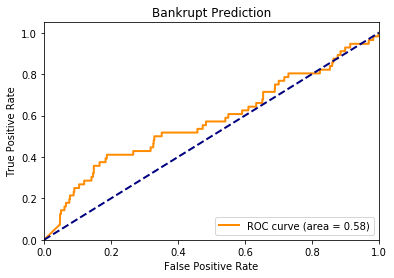

precision    recall  f1-score   support

         0.0    0.99796   0.61168   0.75847     21588
         1.0    0.00345   0.51786   0.00685        56

    accuracy                        0.61144     21644
   macro avg    0.50070   0.56477   0.38266     21644
weighted avg    0.99539   0.61144   0.75653     21644



In [65]:
lr = LogisticRegression(n_jobs = 1)

lr.fit(x_train, y_train)

y_pred = lr.predict_proba(x_test)

fpr,tpr,threshold = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bankrupt Prediction')
plt.legend(loc="lower right")
plt.show()

y_pred_binary = [1 if i >= best_threshold else 0 for i in y_pred[:,1]]

print(classification_report(y_test, y_pred_binary, digits=5))

In [72]:
lr = LogisticRegression(n_jobs = 1)

Cs = [0.001,0.01,0.1,1,10,100,1000]
hyperparameters = dict(C=Cs)
clf = GridSearchCV(lr, hyperparameters, scoring = 'roc_auc', cv=5, verbose=0)
clf.fit(x_train, y_train)
best_model = clf.best_estimator_
best_model.C, clf.best_score_

(100, 0.9662350152661462)

### weighted logistic regression

In [78]:
wlr = LogisticRegression(n_jobs = 1, class_weight={0: 1, 1: 10})

Cs = [0.001,0.01,0.1,1,10,100,1000]
hyperparameters = dict(C=Cs)
clf = GridSearchCV(wlr, hyperparameters, scoring = 'roc_auc', cv=5, verbose=0)
clf.fit(x_train, y_train)
best_model = clf.best_estimator_
best_model.C, clf.best_score_

(1, 0.9568282801717893)

### XG Boost 

In [33]:
xg = xgb.XGBClassifier(n_jobs = 1)

gammas = [0.01,0.1,1,10,100]
hyperparameters = dict(gamma=gammas)
clf = GridSearchCV(xg, hyperparameters, scoring = 'roc_auc', cv=5, verbose=0)
clf.fit(x_train, y_train)
best_model = clf.best_estimator_
best_model.gamma, clf.best_score_

(1, 0.9932530613972024)

In [40]:
best_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [41]:
best_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [43]:
# lr = LogisticRegression(n_jobs = -1)
# # rf = RandomForestClassifier()
# # knn = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1, verbose = True)
# xg = xgb.XGBClassifier(n_jobs = -1)

# lr.fit(x_train, y_train)
# # rf.fit(x_train, y_train)
# # knn.fit(x_train, y_train)
# xg.fit(x_train, y_train)

# y_pred = lr.predict_proba(x_test)
# # y_pred = rf.predict_proba(x_test)
# # y_pred = knn.predict_proba(x_test)
y_pred = best_model.predict_proba(x_test)

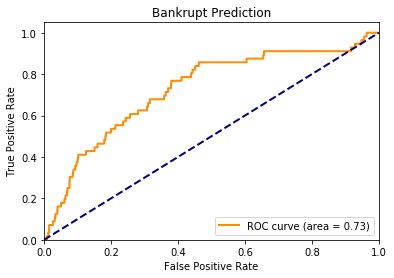

In [44]:
fpr,tpr,threshold = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bankrupt Prediction')
plt.legend(loc="lower right")
plt.show()

Best F1 is 0.02077922077922078 at threshold = [0.88685095]


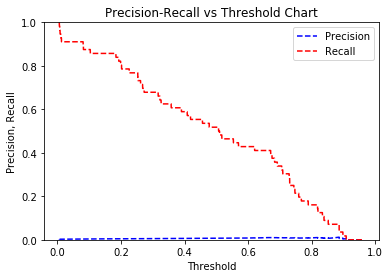

In [47]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
pr_auc = auc(recall, precision)
plt.title("Precision-Recall vs Threshold Chart") 
plt.plot(thresholds, precision[: -1], "b--", label="Precision") 
plt.plot(thresholds, recall[: -1], "r--", label="Recall") 
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.ylim([0,1])

f1 = 2*(precision*recall)/(precision+recall)

best_f1 = max(f1)
best_threshold = thresholds[np.where(f1 == max(f1))]
print(f'Best F1 is {best_f1} at threshold = {best_threshold}')

In [48]:
y_pred_binary = [1 if i >= best_threshold else 0 for i in y_pred[:,1]]

print(classification_report(y_test, y_pred_binary, digits=5))

precision    recall  f1-score   support

         0.0    0.99756   0.98495   0.99121     21588
         1.0    0.01216   0.07143   0.02078        56

    accuracy                        0.98258     21644
   macro avg    0.50486   0.52819   0.50600     21644
weighted avg    0.99501   0.98258   0.98870     21644



## Random Forest

In [35]:
rf = RandomForestClassifier(n_jobs = -1)

rf.fit(x_train, y_train)

y_pred = rf.predict_proba(x_test)

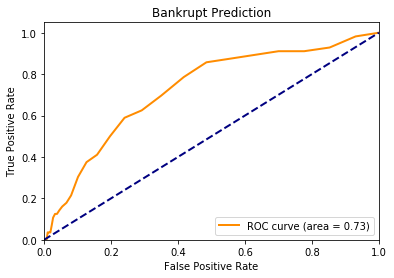

In [36]:
fpr,tpr,threshold = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bankrupt Prediction')
plt.legend(loc="lower right")
plt.show()

Best F1 is 0.08352668213457076 at threshold = [0.3]


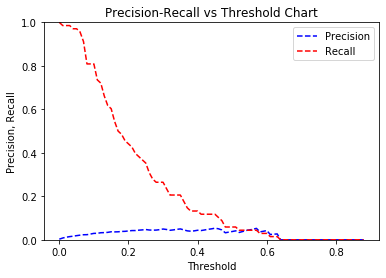

In [70]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
pr_auc = auc(recall, precision)
plt.title("Precision-Recall vs Threshold Chart") 
plt.plot(thresholds, precision[: -1], "b--", label="Precision") 
plt.plot(thresholds, recall[: -1], "r--", label="Recall") 
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.ylim([0,1])

f1 = 2*(precision*recall)/(precision+recall)

best_f1 = max(f1)
best_threshold = thresholds[np.where(f1 == max(f1))]
print(f'Best F1 is {best_f1} at threshold = {best_threshold}')

In [49]:
y_pred_binary = [1 if i >= best_threshold else 0 for i in y_pred[:,1]]

print(classification_report(y_test, y_pred_binary, digits=5))

precision    recall  f1-score   support

         0.0    0.99756   0.98495   0.99121     21588
         1.0    0.01216   0.07143   0.02078        56

    accuracy                        0.98258     21644
   macro avg    0.50486   0.52819   0.50600     21644
weighted avg    0.99501   0.98258   0.98870     21644



In [51]:
feature_imp = sorted(list(zip(rf.feature_importances_, x_train.columns)), key = lambda x: x[0], reverse = True)
feature_imp

[(0.13855922741520416, 'CPI_lag2'),
 (0.12737267933314286, 'CPI_lag1'),
 (0.09981838929146354, 'GDP_lag1'),
 (0.08016844134086114, 'GDP_lag2'),
 (0.0526795046144846, 'lt/at_lag1'),
 (0.04306804387375959, 'at/lt_lag1'),
 (0.03509668593488758, 'roa_lag1'),
 (0.027417184315227404, 'ros_lag1'),
 (0.025149347575982146, 'xint/sale_lag1'),
 (0.02397597996864982, 'wcap/at_lag1'),
 (0.0177298696221981, 'lt/at_lag2'),
 (0.01176004964454137, 'unemployment_lag2'),
 (0.011744532529591949, 'fin_lev_lag1'),
 (0.011481870992751527, 'unemployment_lag1'),
 (0.010743887294428052, 'effective_tax_rate_lag1'),
 (0.010133686806859513, 'inflation_lag1'),
 (0.009614818441490716, 'at/lt_lag2'),
 (0.009060520661412157, 'xint/sale_lag2'),
 (0.008780246396229062, 'ros_lag2'),
 (0.008634452473263974, 'gross_margin_lag1'),
 (0.008495692337324163, 'roe_lag1'),
 (0.007837868882197702, 'spread_lag2'),
 (0.0077589758308339064, 'ebitda/at_lag1'),
 (0.007493757418557895, 'roa_lag2'),
 (0.007452662679508774, 'fin_lev_lag2'

<BarContainer object of 10 artists>

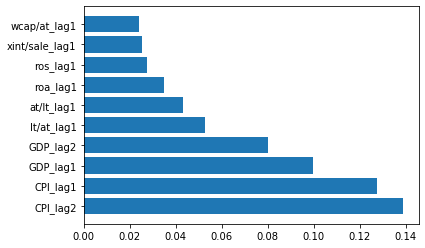

In [64]:
top_x = 10

imp = [i[0] for i in feature_imp][:top_x]
fea = [i[1] for i in feature_imp][:top_x]

plt.barh(fea, imp)

## Neural Network

In [75]:
# Create a Multi-Layer Perceptron Classifier object
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (50, 50, 50, 50, 50), random_state = 42)

In [76]:
# Create a Pipeline for mlp
dnn = Pipeline(steps = [
    ('classifier', mlp)
])

In [77]:
# Fit the pipeline on the training data
dnn.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('classifier',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(50, 50, 50, 50, 50),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [78]:
# Make predictions on test data
y_pred = dnn.predict(x_test)
y_pred_proba = dnn.predict_proba(x_test)

In [79]:
# Calculate prediction accuracy on test data
test_acc = dnn.score(x_test, y_test)
test_acc

0.9944494257290466

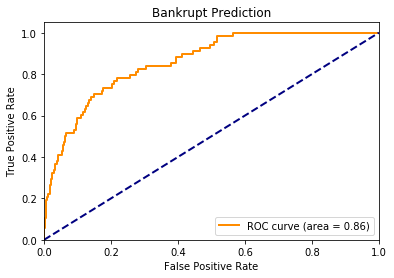

In [80]:
fpr,tpr,threshold = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bankrupt Prediction')
plt.legend(loc="lower right")
plt.show()

Best F1 is 0.11483253588516748 at threshold = [0.03966397]


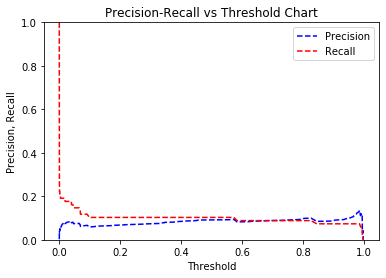

In [81]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:,1])
pr_auc = auc(recall, precision)
plt.title("Precision-Recall vs Threshold Chart") 
plt.plot(thresholds, precision[: -1], "b--", label="Precision") 
plt.plot(thresholds, recall[: -1], "r--", label="Recall") 
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.ylim([0,1])

f1 = 2*(precision*recall)/(precision+recall)

best_f1 = max(f1)
best_threshold = thresholds[np.where(f1 == max(f1))]
print(f'Best F1 is {best_f1} at threshold = {best_threshold}')

In [82]:
y_pred_binary = [1 if i >= best_threshold else 0 for i in y_pred_proba[:,1]]

print(classification_report(y_test, y_pred_binary, digits=5))

precision    recall  f1-score   support

         0.0    0.99759   0.99448   0.99603     23353
         1.0    0.08511   0.17647   0.11483        68

    accuracy                        0.99210     23421
   macro avg    0.54135   0.58547   0.55543     23421
weighted avg    0.99495   0.99210   0.99347     23421



# Perfomance of Best Model on Test Set

# Exploratory Data Analysis #

In [78]:
#! pip install pandas-profiling

In [79]:
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(cm1)
# profile.to_file(outputfile = 'Profile.html')
# profile

In [ ]:
# cmcm.drop(columns=['fyear_lag1','fyear_lag2', 'predict_year', 'bankrupt_year', 'bankrupt'], inplace = True)

In [81]:
# bankrupt = cmcm[cmcm['bankrupt']==1]
# not_bankrupt = cmcm[cmcm['bankrupt']==0]

In [44]:
# for i in list(cmcm)[2:66]:
#     plt.figure(figsize=(8,5), dpi= 80)
#     sns.kdeplot(bankrupt[i], shade=True, color="pink", label="Bankrupt", alpha=.7)
#     sns.kdeplot(not_bankrupt[i], shade=True, color="orange", label="Not Bankrupt", alpha=.7)
# #     sns.kdeplot(DT_df['price'], shade=True, color="lightgreen", label="DT", alpha=.7)
#     plt.title('Density Plot of'+ f'{i}'+ 'by Bankrupt or not', fontsize=10)
#     plt.legend()